# Augmentation

## Data

In [31]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [32]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

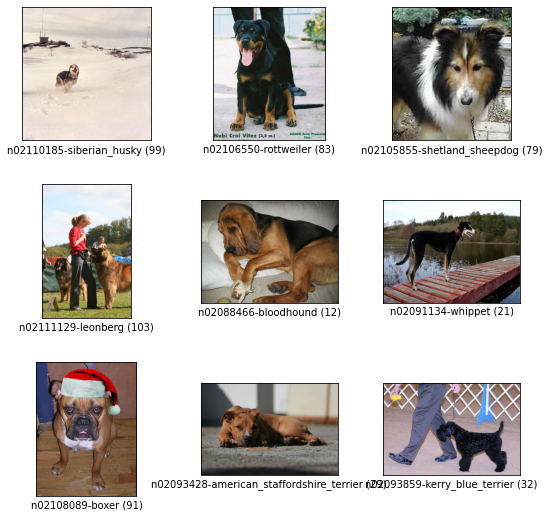

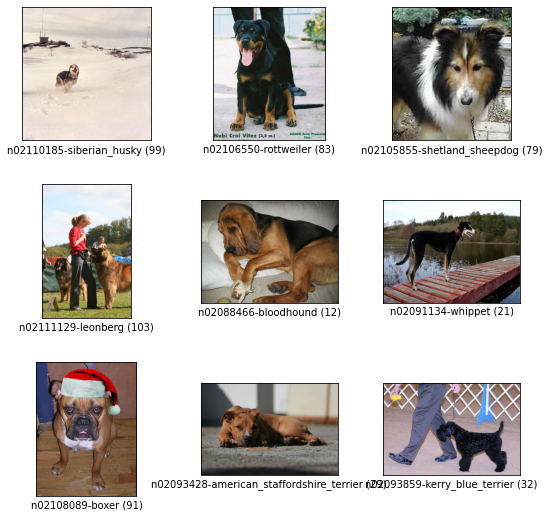

In [34]:
tfds.show_examples(ds_train, ds_info)


## applying augmentation

In [35]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [36]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [37]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## CutMix Augmentation

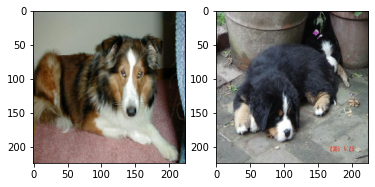

In [38]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [39]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [40]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

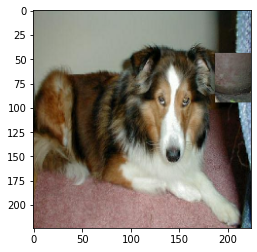

In [41]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [42]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup Augmentation

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.7146481  0.         0.         0.         0.
 0.         0.         0.         0.         0.28535187 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

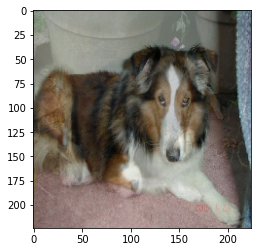

In [43]:
num_classes = ds_info.features["label"].num_classes

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [44]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [45]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [46]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [47]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## model

In [48]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [49]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [50]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [51]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## model training

In [52]:
EPOCH = 20 

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [53]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 129ms/step - loss: 2.1874 - accuracy: 0.4502 - val_loss: 3.7499 - val_accuracy: 0.1472
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.6800 - accuracy: 0.8151 - val_loss: 1.1234 - val_accuracy: 0.6712
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 0.2544 - accuracy: 0.9438 - val_loss: 1.0586 - val_accuracy: 0.6961
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0714 - accuracy: 0.9919 - val_loss: 0.9196 - val_accuracy: 0.7383
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0227 - accuracy: 0.9991 - val_loss: 0.9154 - val_accuracy: 0.7458
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 0.0126 - accuracy: 0.9999 - val_loss: 0.9247 - val_accuracy: 0.7443
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0103 - accuracy: 0.9999 - val_loss: 0.9668 - val_a

In [54]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 126ms/step - loss: 3.8319 - accuracy: 0.2072 - val_loss: 3.5466 - val_accuracy: 0.1884
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 2.9698 - accuracy: 0.4306 - val_loss: 1.3784 - val_accuracy: 0.6142
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 2.6354 - accuracy: 0.5303 - val_loss: 1.3413 - val_accuracy: 0.6416
Epoch 4/20
750/750 [==============================] - 97s 129ms/step - loss: 2.4302 - accuracy: 0.6049 - val_loss: 1.4481 - val_accuracy: 0.6019
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2685 - accuracy: 0.6513 - val_loss: 1.1750 - val_accuracy: 0.6728
Epoch 6/20
750/750 [==============================] - 97s 129ms/step - loss: 2.1633 - accuracy: 0.6891 - val_loss: 1.2485 - val_accuracy: 0.6659
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 2.0593 - accuracy: 0.7167 - val_loss: 1.2503 - val_a

In [55]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 124ms/step - loss: 3.7404 - accuracy: 0.2384 - val_loss: 3.8295 - val_accuracy: 0.1459
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 2.8677 - accuracy: 0.4798 - val_loss: 1.4529 - val_accuracy: 0.5903
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 2.5808 - accuracy: 0.5845 - val_loss: 1.3129 - val_accuracy: 0.6287
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 2.3951 - accuracy: 0.6498 - val_loss: 1.3455 - val_accuracy: 0.6281
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2886 - accuracy: 0.6964 - val_loss: 1.2374 - val_accuracy: 0.6528
Epoch 6/20
750/750 [==============================] - 93s 123ms/step - loss: 2.1626 - accuracy: 0.7389 - val_loss: 1.3226 - val_accuracy: 0.6438
Epoch 7/20
750/750 [==============================] - 94s 125ms/step - loss: 2.0724 - accuracy: 0.7765 - val_loss: 1.4355 - val_a

In [58]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 108s 123ms/step - loss: 2.2900 - accuracy: 0.4301 - val_loss: 2.9661 - val_accuracy: 0.2747
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.9287 - accuracy: 0.7328 - val_loss: 1.6868 - val_accuracy: 0.5441
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 0.4823 - accuracy: 0.8687 - val_loss: 1.2455 - val_accuracy: 0.6370
Epoch 4/20
750/750 [==============================] - 95s 127ms/step - loss: 0.2479 - accuracy: 0.9429 - val_loss: 1.0833 - val_accuracy: 0.6916
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1204 - accuracy: 0.9778 - val_loss: 0.9915 - val_accuracy: 0.7135
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0675 - accuracy: 0.9912 - val_loss: 0.9607 - val_accuracy: 0.7341
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 0.0410 - accuracy: 0.9955 - val_loss: 1.0140 - val_a

## visualization

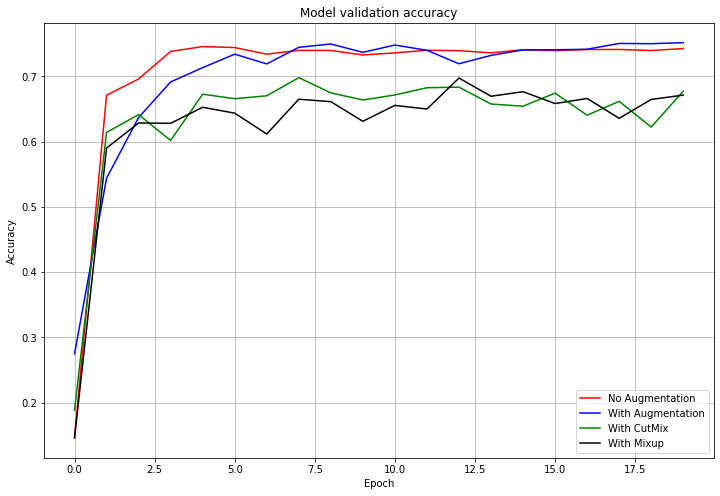

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

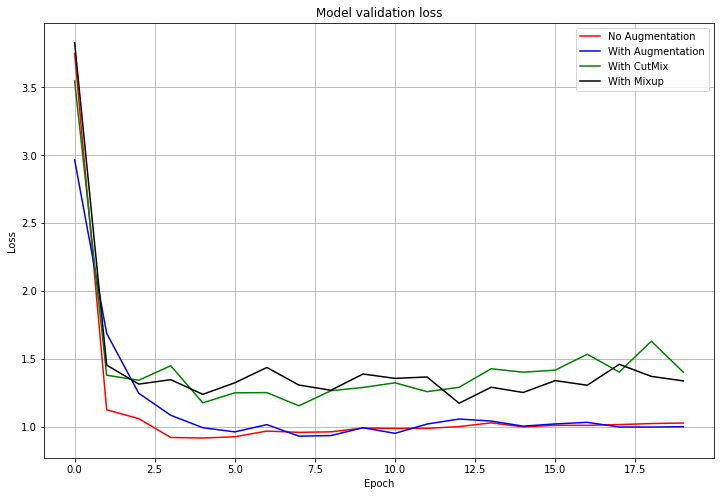

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## comparing

In [61]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df[-3:]

,No Augmentation,With Augmentation,With CutMix,With Mixup
17,0.741371,0.750583,0.661847,0.635844
18,0.739739,0.750233,0.622435,0.664762
19,0.742770,0.751749,0.677355,0.671409


## 회고

마지막 3에포크에서의 정확도를 비교해보았다.

- No Augmentation보다 기본 Augmentation 을 사용했을 때 정확도가 향상되었다.

- 오히려 CutMix 와 Mixup Augmentation을 사용했을 경우에는 no Augmentation보다 정확도가 감소한 것을 확인 할 수 있다.

- 이것은 CutMix 와 Mixup 과정에서 랜덤으로 바운딩박스의 위치를 뽑아서 모델이 학습하는 데에 악영향을 미친것으로 예상할 수 있다.